In [214]:
import grafiti as gf
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import squidpy as sq
from sklearn import metrics
import seaborn as sns
import pandas as pd
import anndata as ad
import torch
import decoupler as dc

import warnings
warnings.filterwarnings('ignore')

datadir = "/data1/shahs3/users/mezallj1/data/merfish"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [215]:
def plot_region(adata, region):
    new_adata = adata[adata.obs['Region']==region]
    sc.pl.embedding(new_adata, basis='spatial', title = '0027465 - Grafiti - Combined', color ='grafiti_motif', s=20, add_outline=True)
    return

# Contrastive Learning - Local DGI - Individual

In [216]:
import scanpy as sc
import scipy.sparse
import numpy as np
import seaborn as sns
import umap
import torch.nn.functional as F
import torch
from torch import Tensor
import torch_scatter
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import models
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import aggr
from torch_geometric.nn import MessagePassing
from sklearn import preprocessing
import random

class GrafitiEncoderLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GrafitiEncoderLayer, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype) 
        return x_j / edge_attr.unsqueeze(-1) 

    def forward(self, x, edge_index, edge_attr):
        ret = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        ret = self.lin(ret) 
        return F.leaky_relu(ret, negative_slope=0.01)
    
class GrafitiDecoderLayer(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super(GrafitiDecoderLayer, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr): 
        edge_attr = edge_attr.to(x_j.dtype)
        degree = x_j.size(0) 
        degree_normalized_message = x_j / edge_attr.unsqueeze(-1) 
        res = degree_normalized_message / degree
        return res

    def aggregate(self, inputs, index, dim_size=None):
        res = torch_scatter.scatter_mean(inputs, index, dim=0, dim_size=dim_size)
        return res

    def forward(self, x, edge_index, edge_attr):
        aggr_out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        transformed_features = x - aggr_out
        transformed_features = self.lin(transformed_features) 
        return F.leaky_relu(transformed_features, negative_slope=0.01)
    

class GrafitiEncoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[10,10]):
        super(GrafitiEncoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiEncoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiEncoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class GrafitiDecoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[30,30]):
        super(GrafitiDecoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiDecoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiDecoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, emb, mask=None):
        vsum = torch.mm(mask, emb)
        row_sum = torch.sum(mask, 1).to_dense()
        row_sum = row_sum.expand((vsum.shape[1], row_sum.shape[0])).T
        global_emb = vsum / row_sum 
          
        return F.normalize(global_emb, p=2, dim=1)

class Discriminator(nn.Module):
    def __init__(self, n_hidden_layers, device):
        super(Discriminator, self).__init__()
        self.bilin = nn.Bilinear(n_hidden_layers, n_hidden_layers, 1).to(device)  # Bilinear layer to compute similarity

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            nn.init.xavier_uniform_(m.weight.data)  # Initialize weights
            if m.bias is not None:
                m.bias.data.fill_(0.0)  # Initialize bias

    def forward(self, s, h, h_a, s_bias1=None, s_bias2=None):
        s_x = s.expand_as(h)  # Expand s to match the size of h

        sc_1 = self.bilin(h, s_x)  # Compute similarity score for positive samples
        sc_2 = self.bilin(h_a, s_x)  # Compute similarity score for negative samples

        if s_bias1 is not None:
            sc_1 += s_bias1  # Add bias to positive scores
        if s_bias2 is not None:
            sc_2 += s_bias2  # Add bias to negative scores

        logits = torch.cat((sc_1, sc_2), 1)  # Concatenate scores to form logits

        return logits
        
class GAE(object):

    def __init__(self, adata, layers=[10,10], lr=0.00001, distance_threshold=None, exponent=2, distance_scale=None, device='cpu', alpha=10, beta=1, gamma=1, seed=42):
        seed_everything(seed)  # Seed everything for reproducibility
        self.lr = lr
        self.device = torch.device(device)
        print("Generating PyTorch Geometric Dataset...")
        if distance_threshold != None:
            distances = adata.obsp["spatial_distances"]
            connectiv = adata.obsp["spatial_connectivities"]
            rows, cols = distances.nonzero()
            for row, col in zip(rows, cols):
                if distances[row, col] > distance_threshold:
                    connectiv[row, col] = 0
            adata.obsp["spatial_connectivities"] = connectiv
        self.adj = adata.obsp["spatial_connectivities"]
        self.graph_neigh = sparse_mx_to_torch_sparse_tensor(self.adj + scipy.sparse.identity(self.adj.shape[0], format='csr'),self.device)
        edges = self.adj.nonzero()

        # Check if adata.X is a scipy.sparse.csr_matrix
        if scipy.sparse.issparse(adata.X):
            x = torch.from_numpy(adata.X.toarray())
        else:
            x = torch.from_numpy(adata.X)

        x = x.float().to(self.device)
        e = torch.from_numpy(np.array(edges)).type(torch.int64).to(self.device)
        attrs = [adata.obsp["spatial_distances"][x,y] for x,y in zip(*edges)]
        if distance_scale!=None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,distance_scale))
            attrs = scaler.fit_transform(np.array(attrs).reshape(-1,1)).reshape(1,-1)
            attrs = 1. / (np.array(attrs)**exponent)
            attrs = attrs[0]
        else:
            attrs = np.array(attrs)
        data = Data(x=x, edge_index=e, edge_attr=attrs)
        self.adata = adata
        data.edge_attr = torch.from_numpy(data.edge_attr).to(self.device)
        self.encoder_layers = layers
        self.decoder_layers = list(reversed(layers[1:])) + [data.num_features]
        print("Setting up Model...")
        self.encoder = GrafitiEncoderModule(data.num_features,layers=self.encoder_layers).to(self.device)
        self.decoder = GrafitiDecoderModule(layers[-1],layers=self.decoder_layers).to(self.device)
        self.gae = models.GAE(encoder=self.encoder,decoder=self.decoder).to(self.device)
        self.optimizer = torch.optim.Adam(self.gae.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma)
        self.contrastive_loss = nn.BCEWithLogitsLoss()
        self.reconstruction_loss = nn.MSELoss()
        self.losses = []
        self.global_epoch = 0
        self.data = data
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(layers[-1], self.device)
        self.alpha = alpha # Importance parameter for reconstruction loss
        self.beta = beta # Importance parameter for contrastive loss
        self.gamma = gamma # Parameter for learning rate scheduler
        print("Ready to train!")

    def train(self, epochs, update_interval=5, threshold=0.001, patience=10):
        prev_loss = np.inf
        best_loss = np.inf
        patience_counter = 0 # Counter to track the number of epochs without improvement

        for i in range(epochs):
            self.optimizer.zero_grad()

            # Preparing augmented data
            x_a = augmented_features(self.data.x) # Dynamic augmentation
            self.data.x_a = x_a

            # Encoding original and corrupted graph to latent space
            h = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            h_a = self.gae.encode(self.data.x_a, self.data.edge_index, self.data.edge_attr)\

            self.h = h

            # Summarizing latent embeddings of the original  graph to capture global context
            s = self.read(h, self.graph_neigh).to(self.device)
            s = self.sigm(s).to(self.device) # Normalize to 0-1 probabilities

            self.s = s
            
            # Construction of logits (raw scores that represent the similarity between node embeddings and the summary vector)
            logits = self.disc(s, h, h_a)
            
            # Constrastive Loss
            labels = torch.cat([torch.ones(logits.shape[0], 1), torch.zeros(logits.shape[0], 1)], dim=1).to(logits.device)   
            contrastive_loss = self.contrastive_loss(logits, labels)
            
            # Reconstruction Loss
            reconstruction = self.gae.decode(h, self.data.edge_index, self.data.edge_attr)
            reconstruction_loss = self.reconstruction_loss(reconstruction, self.data.x)

            # Total Loss with the importance parameters
            loss = self.alpha * reconstruction_loss + self.beta * contrastive_loss
            loss.backward()
            self.optimizer.step() 
            self.scheduler.step() # Step the learning rate scheduler
            self.losses.append(loss.item())
            if i % update_interval == 0:
                print("Epoch {} ** iteration {} ** Loss: {}".format(self.global_epoch, i, np.mean(self.losses[-update_interval:])))
            self.global_epoch += 1
            curr_loss = loss.item()

            # Check for improvement
            if curr_loss < best_loss - threshold:
                best_loss = curr_loss
                patience_counter = 0 # Reset the counter if there is an improvement
            else:
                patience_counter += 1

            # Early stopping condition
            if patience_counter >= patience:
                print("Early stopping due to no improvement over {} epochs.".format(patience))
                break

            prev_loss = curr_loss # Update previous loss

        print("Training Complete.")

    def __str__(self):
        fmt = "Pytorch Dataset\n\n"
        fmt += str(self.data) + "\n\n"
        fmt += "GAE Architecture\n\n"
        fmt += str(self.gae) + "\n"
        return fmt

    def plot(self):
        sns.lineplot(self.losses)

    def save(self, path):
        torch.save(self.gae.state_dict(), path)
    
    def load(self, path):
        state_dict = torch.load(path)
        self.gae.load_state_dict(state_dict)

    def load_embedding(self, adata, encoding_key="X_grafiti"):
        with torch.no_grad():
            z = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            h = self.gae.decode(z, self.data.edge_index, self.data.edge_attr)
            hcpu = h.detach().cpu().numpy()
            adata.obsm[encoding_key] = hcpu
            #zcpu = z.detach().cpu().numpy()
            #adata.obsm[encoding_key] = zcpu

In [217]:
def augmented_features(x):
    """Randomly permute the node features to create corrupted features."""
    perm = torch.randperm(x.size(0))
    return x[perm] 

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sparse_mx_to_torch_sparse_tensor(sparse_mx, device):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape).to(device)

In [218]:
adata = sc.read_h5ad(f'{datadir}/raw/MERFISH_0.04.h5ad')

In [219]:
adata

AnnData object with n_obs × n_vars = 5488 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region'
    uns: 'domain_colors'
    obsm: 'spatial'

In [116]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [203]:
gae = GAE(adata, layers=[100,100], lr=0.0001, device=device, alpha=1, beta=10, gamma=1)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [204]:
gae.train(10000, update_interval=100, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 51.956886291503906
Epoch 100 ** iteration 100 ** Loss: 31.69652326583862
Epoch 200 ** iteration 200 ** Loss: 22.88278289794922
Epoch 300 ** iteration 300 ** Loss: 20.104677925109865
Epoch 400 ** iteration 400 ** Loss: 18.394024505615235
Epoch 500 ** iteration 500 ** Loss: 17.076326503753663
Early stopping due to no improvement over 10 epochs.
Training Complete.


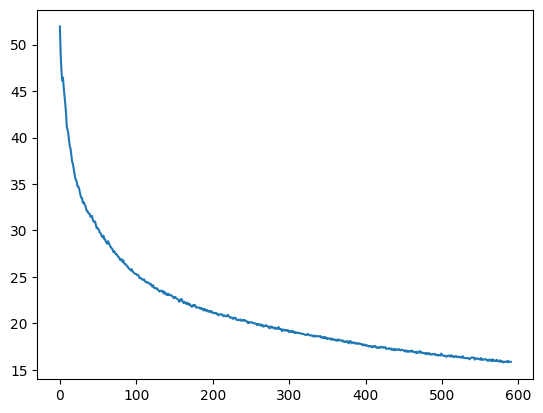

In [205]:
gae.plot()

In [206]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [207]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=20, random_state=42) 
#embedding = pca.fit_transform(adata.obsm['X_grafiti'].copy())
#adata.obsm['X_grafiti_pca'] = embedding

In [208]:
gf.tl.umap(adata, encoding_key='X_grafiti') # Embed grafiti latent space into umap latent space (2 dimensions)
#gf.tl.umap(adata, encoding_key='X_grafiti_pca') # Embed grafiti latent space into umap latent space (2 dimensions)

In [209]:
gf.tl.find_motifs_gmm(adata,k=8,embedding_key='X_grafiti')
#gf.tl.find_motifs_gmm(adata,k=16,embedding_key='X_grafiti_pca')
#gf.tl.find_motifs(adata, resolution=0.5, cluster_key="grafiti_motif", neighbor_method="umap", n_neighbors=10, prefix="GrafitiMotif", encoding_key="X_grafiti",method="leiden",metric="euclidean",k=12,max_iter=10,use_weights=False, compute_neighbors=True)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=8, random_state=0,
                verbose=True)

In [210]:
obs_df = adata.obs.dropna()

In [211]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.10157334078891302


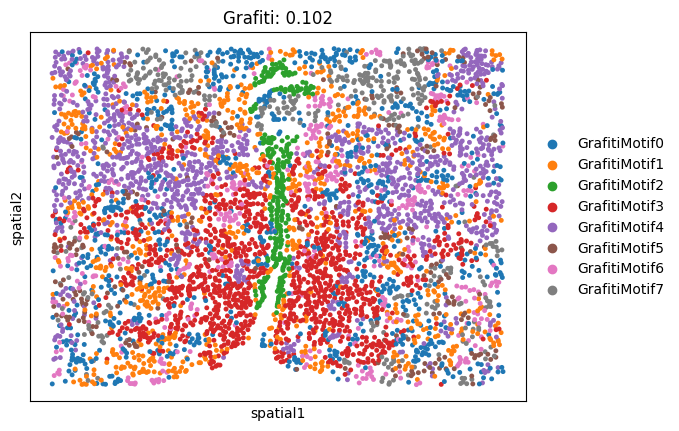

In [212]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

In [213]:
adata.X

array([[1.5691678e+01, 0.0000000e+00, 0.0000000e+00, ..., 9.5359758e-03,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 4.4281268e+00, ..., 0.0000000e+00,
        1.9590545e-02, 8.4548555e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 8.8409437e-03],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        7.2741760e-03, 5.3044381e-03],
       [0.0000000e+00, 6.2775862e-01, 3.1387577e+00, ..., 0.0000000e+00,
        1.7380010e-02, 2.9591622e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        4.2025042e-03, 8.6551262e-03]], dtype=float32)

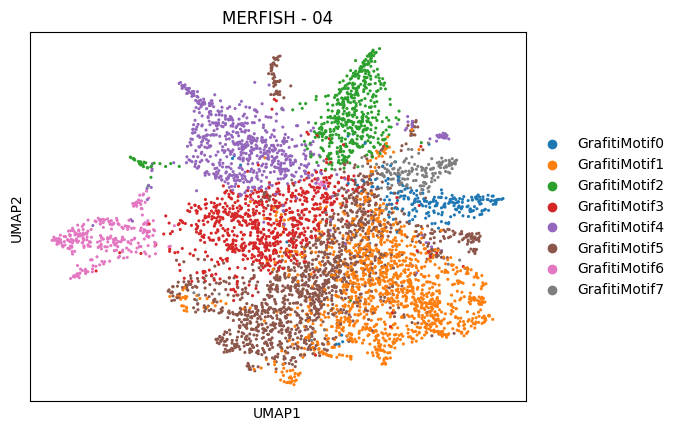

In [202]:
sc.pl.umap(adata,title="MERFISH - 04",color=["grafiti_motif"],s=20)